In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [3]:
data=pd.read_csv("data m.csv")
data

,Date,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
0,12/31/2002,6.763,13.495,1.238,-4.053,6.52
1,1/31/2003,6.769,13.494,1.235,-3.288,6.52
2,2/28/2003,6.774,13.489,1.262,-3.684,6.52
3,3/31/2003,6.778,13.492,1.253,-3.664,6.53
4,4/30/2003,6.782,13.510,1.258,-4.162,6.53
...,...,...,...,...,...,...
220,4/30/2021,7.691,15.867,0.069,-2.828,7.68
221,5/31/2021,7.700,15.878,0.058,-1.116,7.68
222,6/30/2021,7.698,15.898,0.078,-1.094,7.69
223,7/31/2021,7.696,15.918,0.098,0.611,7.69


In [4]:
data = data.set_index('Date')
data

,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
Date,,,,,
12/31/2002,6.763,13.495,1.238,-4.053,6.52
1/31/2003,6.769,13.494,1.235,-3.288,6.52
2/28/2003,6.774,13.489,1.262,-3.684,6.52
3/31/2003,6.778,13.492,1.253,-3.664,6.53
4/30/2003,6.782,13.510,1.258,-4.162,6.53
...,...,...,...,...,...
4/30/2021,7.691,15.867,0.069,-2.828,7.68
5/31/2021,7.700,15.878,0.058,-1.116,7.68
6/30/2021,7.698,15.898,0.078,-1.094,7.69


In [5]:
data_diff = data.diff(year).dropna()
data_diff

,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
Date,,,,,
12/31/2003,0.038,0.046,-0.254,1.032,0.05
1/31/2004,0.037,0.047,-0.238,0.369,0.05
2/29/2004,0.039,0.044,-0.255,1.102,0.05
3/31/2004,0.044,0.043,-0.251,0.405,0.04
4/30/2004,0.047,0.034,-0.254,1.602,0.04
...,...,...,...,...,...
4/30/2021,0.116,0.211,0.020,112.840,0.14
5/31/2021,0.069,0.124,0.008,84.519,0.11
6/30/2021,0.046,0.118,0.000,48.659,0.11


In [6]:
data_new = data_diff.diff(year).dropna()

In [7]:
data_new

,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
Date,,,,,
12/31/2004,0.032,0.017,1.426,0.033,-8.881784e-16
1/31/2005,0.026,0.013,1.520,0.889,-8.881784e-16
2/28/2005,0.021,0.016,1.750,-0.450,-8.881784e-16
3/31/2005,0.009,0.017,1.878,1.479,1.000000e-02
4/30/2005,0.004,0.019,2.035,-0.470,1.000000e-02
...,...,...,...,...,...
4/30/2021,-0.084,-0.260,2.395,228.572,5.000000e-02
5/31/2021,-0.182,-0.461,2.349,170.165,-8.881784e-16
6/30/2021,-0.220,-0.500,2.300,98.492,-1.000000e-02


In [10]:
df = data_new

In [11]:
column_names = {'Log M4 including Treasuries':'P',
                'Log Total Assets': 'Q',
                'Log Currency in Circulation ($ Bil)':'X',
                'Effective Federal Funds Rate (%)':'Y', 
                'Loss Function':'Z'}

# rename columns
df = df.rename(columns = column_names)

In [12]:
df

,P,Q,Y,Z,X
Date,,,,,
12/31/2004,0.032,0.017,1.426,0.033,-8.881784e-16
1/31/2005,0.026,0.013,1.520,0.889,-8.881784e-16
2/28/2005,0.021,0.016,1.750,-0.450,-8.881784e-16
3/31/2005,0.009,0.017,1.878,1.479,1.000000e-02
4/30/2005,0.004,0.019,2.035,-0.470,1.000000e-02
...,...,...,...,...,...
4/30/2021,-0.084,-0.260,2.395,228.572,5.000000e-02
5/31/2021,-0.182,-0.461,2.349,170.165,-8.881784e-16
6/30/2021,-0.220,-0.500,2.300,98.492,-1.000000e-02


In [13]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [14]:
residuals

,P,Q,Y,Z,X
Date,,,,,
12/31/2004,0.059827,0.152700,1.855017,5.155756,-0.021764
1/31/2005,0.056224,0.156184,1.873026,5.027805,-0.021281
2/28/2005,0.055355,0.173019,2.053002,3.260016,-0.022327
3/31/2005,0.037816,0.121124,1.826200,1.102415,-0.011616
4/30/2005,0.035028,0.129667,1.929233,-1.385218,-0.011839
...,...,...,...,...,...
4/30/2021,0.045325,0.116503,0.086475,194.172255,0.022318
5/31/2021,-0.045412,0.062672,-0.575587,124.971789,0.018164
6/30/2021,-0.117988,-0.092925,-1.067437,48.316728,0.032020


In [15]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,P,Q,Y,Z,X
P,1.00,-0.09,-0.48,-0.30,0.42
Q,-0.09,1.00,-0.47,-0.30,0.72
Y,-0.48,-0.47,1.00,-0.04,0.44
Z,-0.30,-0.30,-0.04,1.00,0.21
X,0.42,0.72,0.44,0.21,1.00


In [16]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

,P,Q,Y,Z,X
P,1.00,-0.09,-0.48,-0.30,0.42
Q,-0.09,1.00,-0.47,-0.30,0.72
Y,-0.48,-0.47,1.00,-0.04,0.44
Z,-0.30,-0.30,-0.04,1.00,0.21
X,0.42,0.72,0.44,0.21,1.00


C:\Users\proma.gupta\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


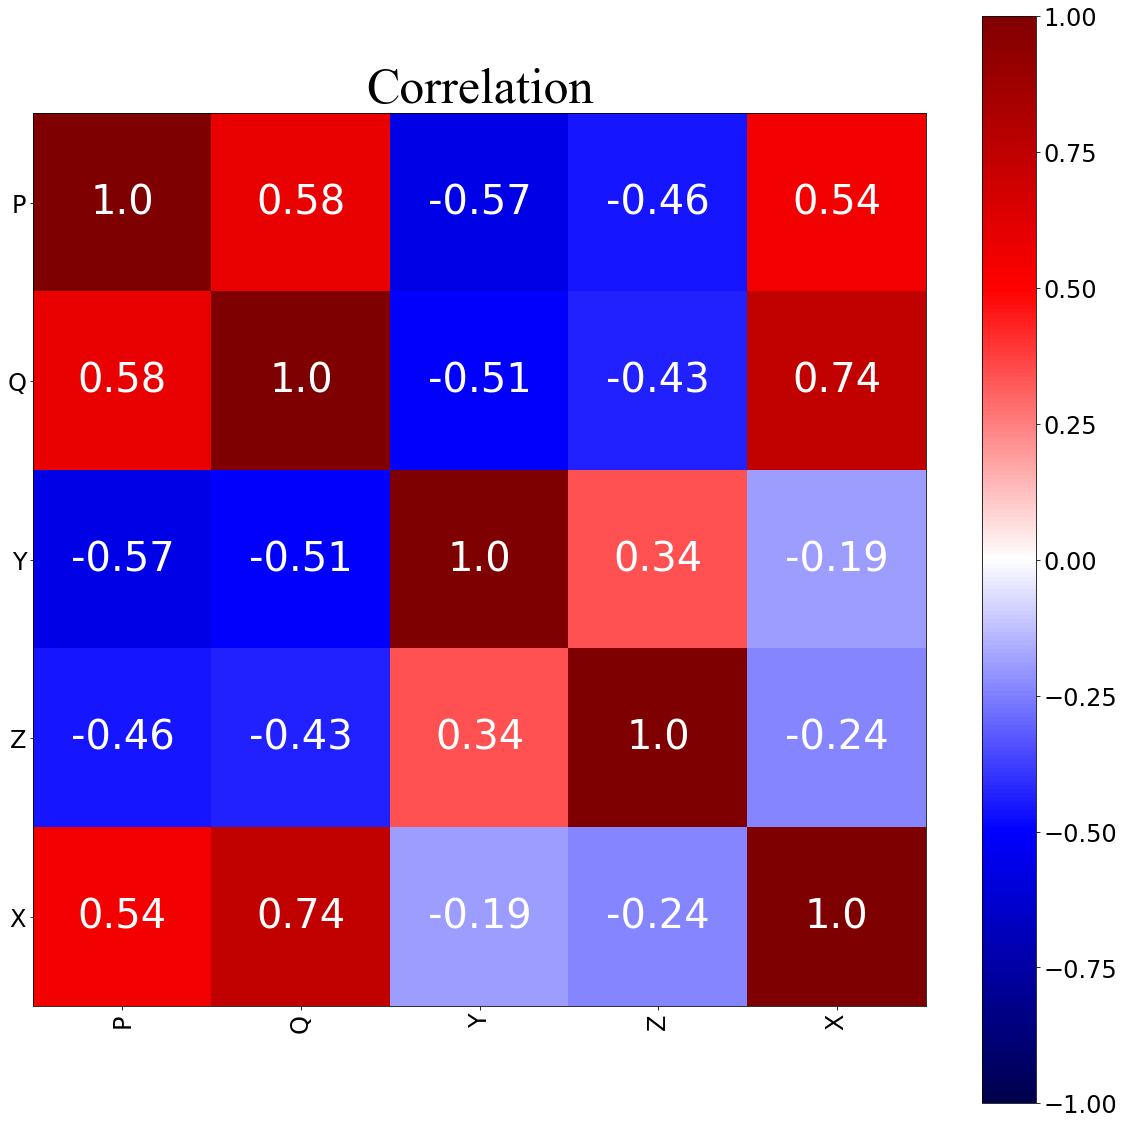

TypeError: corr_matrix_heatmap() got an unexpected keyword argument 'title'

In [17]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None)
corr_matrix_heatmap(df.pcorr(), save_fig = False, pp = None, title = "Partial Correlation")

In [18]:
residuals

,P,Q,Y,Z,X
Date,,,,,
12/31/2004,0.059827,0.152700,1.855017,5.155756,-0.021764
1/31/2005,0.056224,0.156184,1.873026,5.027805,-0.021281
2/28/2005,0.055355,0.173019,2.053002,3.260016,-0.022327
3/31/2005,0.037816,0.121124,1.826200,1.102415,-0.011616
4/30/2005,0.035028,0.129667,1.929233,-1.385218,-0.011839
...,...,...,...,...,...
4/30/2021,0.045325,0.116503,0.086475,194.172255,0.022318
5/31/2021,-0.045412,0.062672,-0.575587,124.971789,0.018164
6/30/2021,-0.117988,-0.092925,-1.067437,48.316728,0.032020


In [19]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,P,Q,Y,Z,X
P,NaN,0.22,0.00,0.00,0.0
Q,0.22,NaN,0.00,0.00,0.0
Y,0.00,0.00,NaN,0.53,0.0
Z,0.00,0.00,0.53,NaN,0.0
X,0.00,0.00,0.00,0.00,NaN


In [20]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in df.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph

{'P': ['Q', 'Y', 'Z', 'X'],
 'Q': ['P', 'Y', 'Z', 'X'],
 'Y': ['P', 'Q', 'Z', 'X'],
 'Z': ['P', 'Q', 'Y', 'X'],
 'X': ['P', 'Q', 'Y', 'Z']}

In [21]:
import copy
p_val = .01
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        for c_var in control_vars:
            # set c_used every time use cycle through a new control
            #  the program will then iterate through remaining controls
            #  until statistical significance is broken
            c_used = copy.copy(controls_used)
            if y in undirected_graph[x]:

                c_used.append(c_var)
                test = df.partial_corr(x = x, y = y, covar=c_used,
                                      method = "pearson")
                if test["p-val"].values[0] > p_val: 

                    undirected_graph[x].remove(y)
                    #breakout of the for 
                    break
                else:
                    remaining_controls = copy.copy(control_vars)
                    remaining_controls.remove(c_var)
                    # recursive function that iterates through remaining variables 
                    #  uses them as controls statistical significance holds without them,
                    #  otherwise break
                    check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
                
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, 
                                       y = y, 
                                       covar = None,
                                       method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'P': ['Y', 'Z', 'X'],
 'Q': ['Y', 'Z', 'X'],
 'Y': ['P', 'Q'],
 'Z': ['P', 'Q'],
 'X': ['P', 'Q']}

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                # edge label is partial correlation between
                # key and key2
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    plt.show()

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

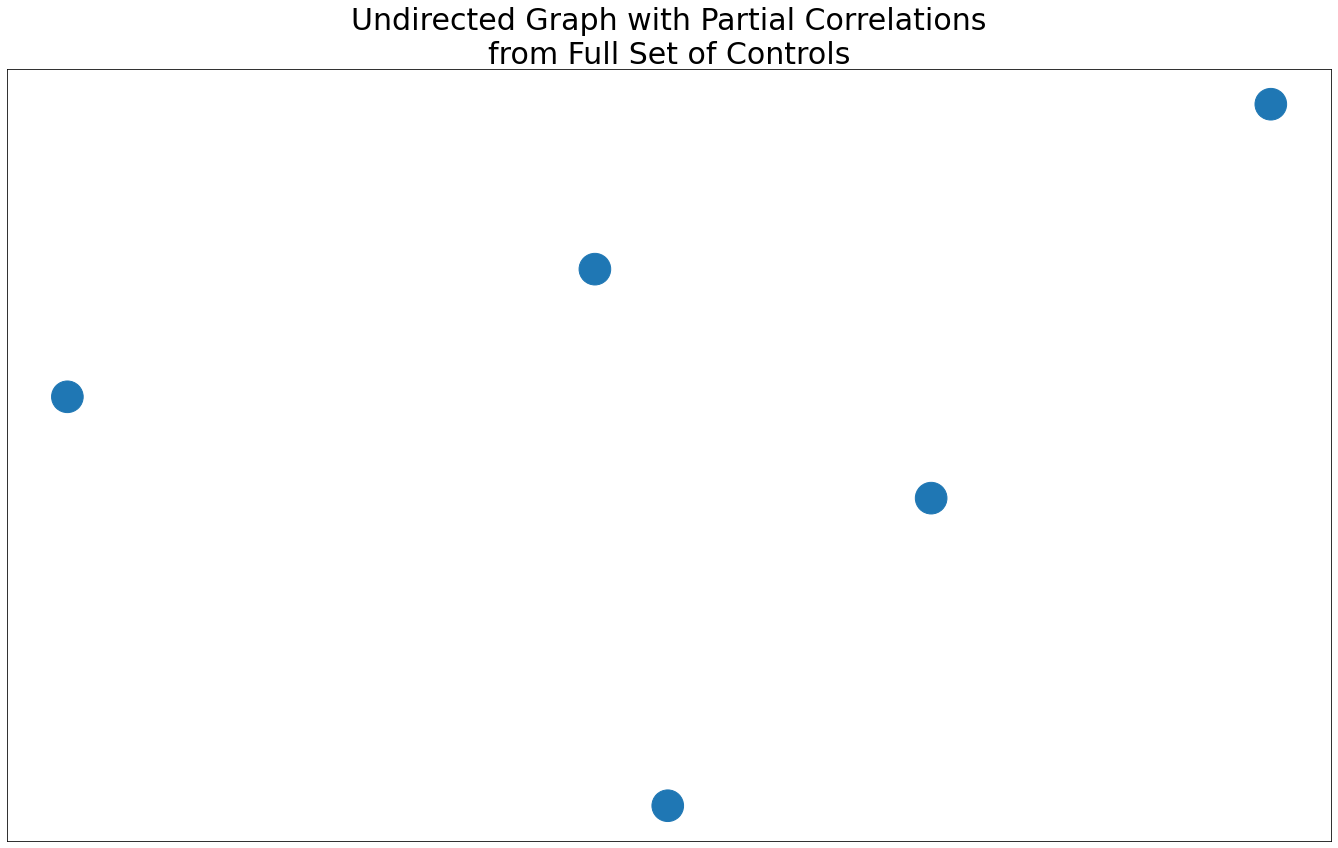

In [23]:
graph_DAG(undirected_graph, df, title = "Undirected Graph with Partial Correlations\nfrom Full Set of Controls")

In [24]:
## Estimating a Directed Acyclic Graph

from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) - 2


model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

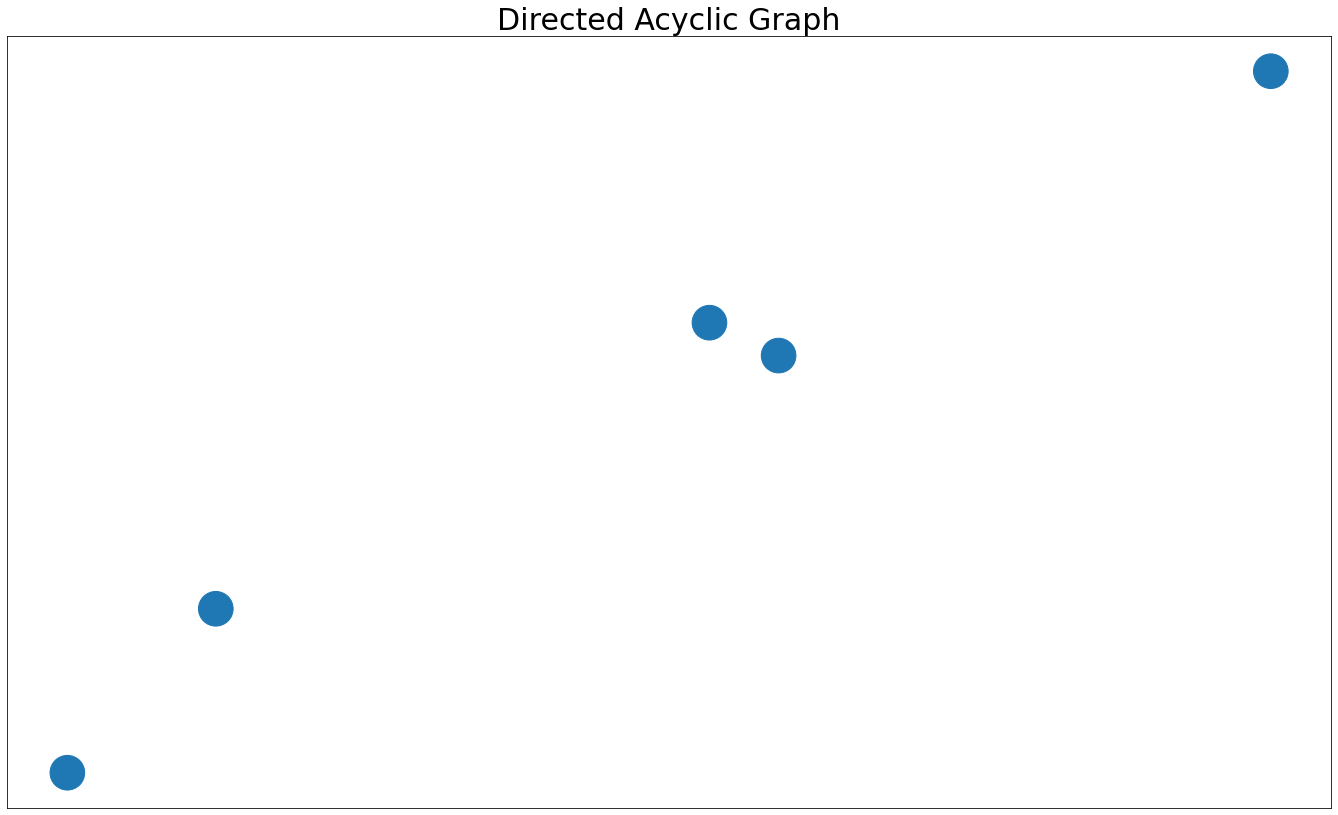

In [25]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

keep control: Y
('X', 'P') ['Y']
keep control: Y
('X', 'Q') ['Y']
keep control: X
('Y', 'Q') ['X']
keep control: X
('Y', 'P') ['X']
('Q', 'Z') []


AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

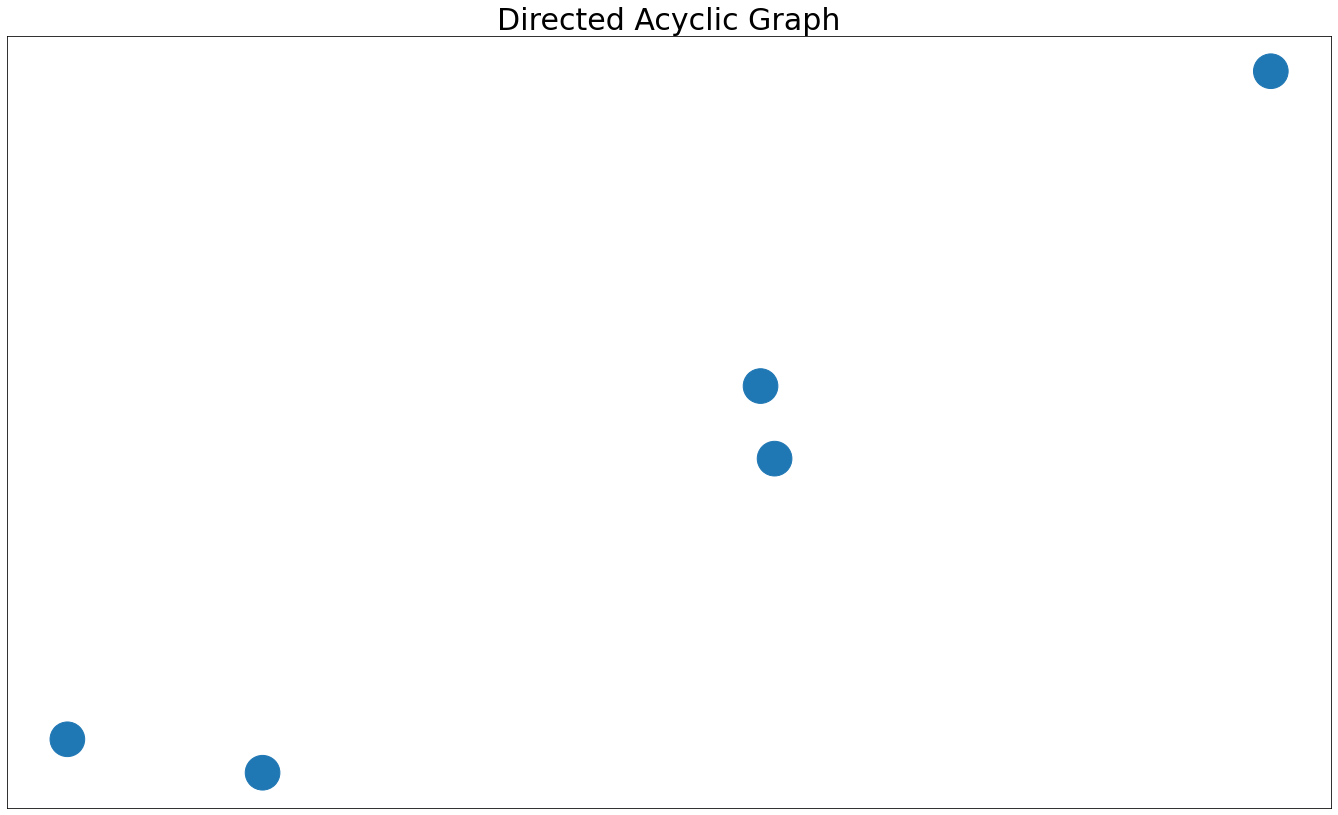

In [26]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")